## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator#, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [4]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5
ROOT_PATH = "C:\\Users\\alber\\Downloads\\dogs-vs-cats\\"

TRAIN_PATH_TOT = ROOT_PATH + "train\\train\\"

MINI_TRAIN_PATH = ROOT_PATH + "mini_train\\"
MINI_TEST_PATH = ROOT_PATH + "mini_test\\"

TRAIN_PATH = TRAIN_PATH_TOT


# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [8]:
len(os.listdir(TRAIN_PATH))

25000

In [6]:
filenames = os.listdir(TRAIN_PATH)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


### See Total In count

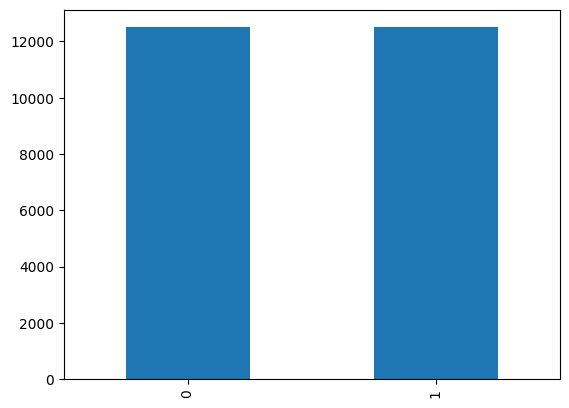

In [10]:
df['category'].value_counts().plot.bar();

# See sample image

(374, 500, 3)
255


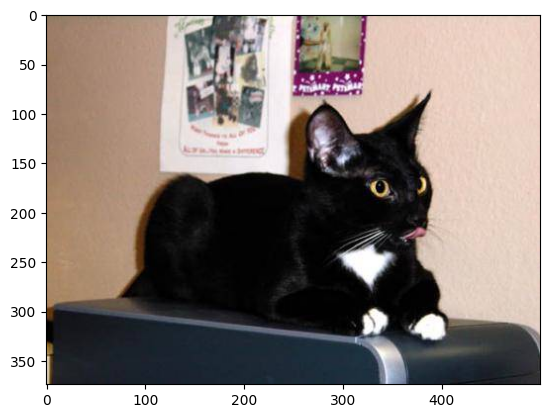

In [16]:
'''
Tres canales para el RGB.
Todas las imagágenes en diferentes resoluciones. Esto es un problema.
Todas tienen que llevar las mismas dimensiones para la entrada a la red
'''
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [17]:
image

array([[[137, 120,  94],
        [137, 120,  94],
        [137, 120,  94],
        ...,
        [227, 210, 194],
        [226, 209, 193],
        [225, 208, 192]],

       [[137, 120,  94],
        [137, 120,  94],
        [138, 121,  95],
        ...,
        [227, 210, 194],
        [226, 209, 193],
        [225, 208, 192]],

       [[140, 120,  95],
        [140, 120,  95],
        [140, 120,  95],
        ...,
        [229, 210, 195],
        [228, 209, 194],
        [227, 208, 193]],

       ...,

       [[212, 199, 190],
        [212, 199, 182],
        [202, 188, 153],
        ...,
        [ 45,  43,  46],
        [ 58,  56,  59],
        [ 77,  75,  78]],

       [[212, 199, 190],
        [211, 198, 181],
        [201, 187, 152],
        ...,
        [ 45,  43,  46],
        [ 58,  56,  59],
        [ 77,  75,  78]],

       [[212, 199, 190],
        [211, 198, 181],
        [200, 186, 151],
        ...,
        [ 45,  43,  46],
        [ 58,  56,  59],
        [ 77,  75,  78]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (399, 500, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 255


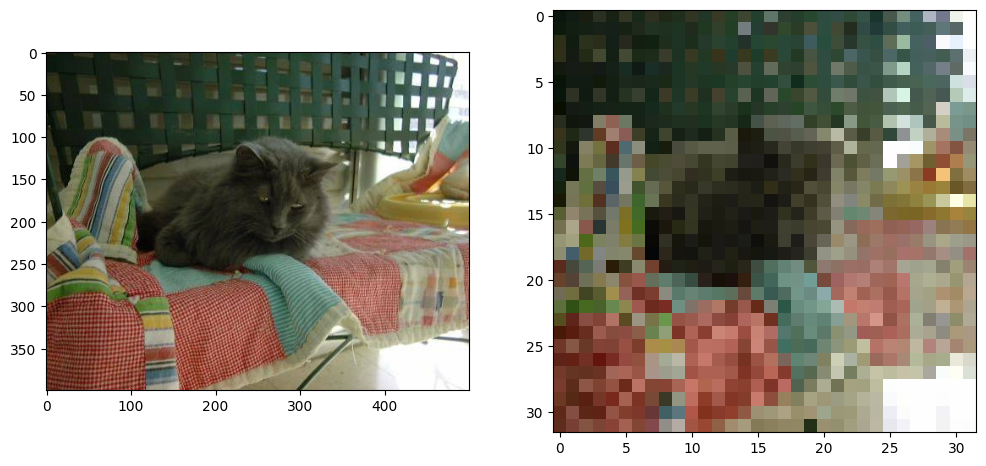

In [18]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Dimensiones: (374, 500)
Maximo color: 255


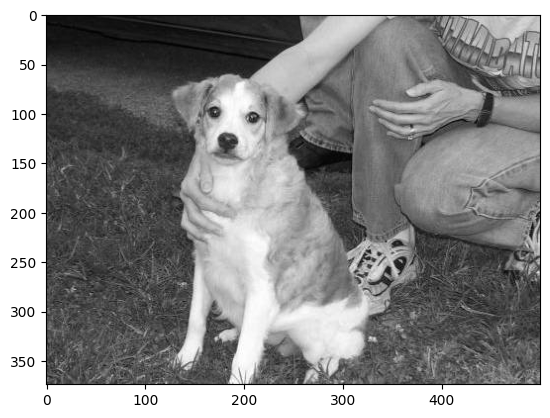

In [20]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH + sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(df['filename'], df['category'], random_state=0, train_size=.8 )

# X_train.to_csv('train_files.csv', index=False)
# X_test.to_csv('test_files.csv', index=False)

X_train = pd.read_csv('train_files.csv')
X_test = pd.read_csv('test_files.csv')

y_train = X_train['filename'].apply(lambda x: x.split('.')[0])
y_test = X_test['filename'].apply(lambda x: x.split('.')[0])



<AxesSubplot: >

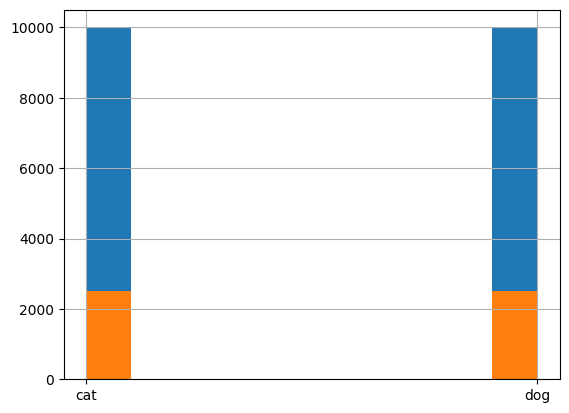

In [24]:
y_train.hist()
y_test.hist()

In [14]:
def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(MINI_TRAIN_PATH, IMAGE_SIZE)
X_test, y_test = read_data(MINI_TEST_PATH, IMAGE_SIZE)

print(X_train.shape)
print(X_test.shape)

(20000, 32, 32, 3)
(5000, 32, 32, 3)


(32, 32, 3)


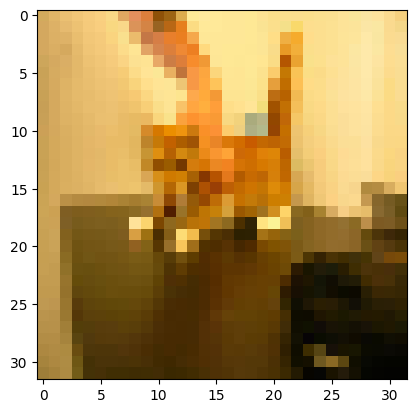

In [16]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [17]:
X_train[0]

array([[[210, 171,  93],
        [224, 181, 103],
        [235, 192, 114],
        ...,
        [253, 227, 157],
        [250, 218, 143],
        [245, 208, 127]],

       [[212, 168,  95],
        [221, 177, 102],
        [230, 186, 111],
        ...,
        [250, 231, 162],
        [250, 218, 143],
        [244, 215, 137]],

       [[212, 168,  95],
        [220, 176, 101],
        [222, 178, 103],
        ...,
        [249, 230, 161],
        [251, 219, 144],
        [249, 219, 147]],

       ...,

       [[173, 136,  65],
        [176, 139,  68],
        [173, 139,  65],
        ...,
        [ 10,  10,   2],
        [ 11,  10,   5],
        [  9,   8,   3]],

       [[166, 132,  61],
        [173, 136,  65],
        [174, 140,  68],
        ...,
        [  5,   6,   1],
        [  4,   5,   0],
        [  4,   5,   0]],

       [[158, 126,  57],
        [166, 131,  60],
        [173, 139,  67],
        ...,
        [  4,   4,   1],
        [  3,   3,   1],
        [  3,   3,   1]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [18]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [19]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [20]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [21]:
np.savez(ROOT_PATH + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [25]:
data = np.load(ROOT_PATH + 'data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [26]:
print(X_train.shape)
print(X_test.shape)

(20000, 32, 32, 3)
(5000, 32, 32, 3)


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [144]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
'''
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
'''

"\nmodel = Sequential()\n\nmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(128, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(512, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(2, activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['accuracy'])\n"

In [28]:
32 * 32 * 3, 6 * 6 * 64

(3072, 2304)

In [29]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)
'''
sparse_categorical_crossentropy para cuando las categorias vienen en una unica columna
categorical_crossentropy para cuando las categorias vienen en formato dummy
'''
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
6 * 6 * 64

2304

In [35]:
3 * 3 * 64 * 64 + 64

36928

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

# Callbacks
#### Early Stopping

In [36]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=3)

# Fit the model

In [37]:
history = model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=BATCH_SIZE,
          callbacks = [earlystop],
          validation_split=0.2)

Epoch 1/10
1600/1600 [==============================] - 23s 13ms/step - loss: 0.6449 - accuracy: 0.6169 - val_loss: 0.5850 - val_accuracy: 0.6952
Epoch 2/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.5474 - accuracy: 0.7224 - val_loss: 0.5151 - val_accuracy: 0.7393
Epoch 3/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.4949 - accuracy: 0.7629 - val_loss: 0.5148 - val_accuracy: 0.7355
Epoch 4/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.4690 - accuracy: 0.7782 - val_loss: 0.5292 - val_accuracy: 0.7423
Epoch 5/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.4384 - accuracy: 0.7986 - val_loss: 0.4631 - val_accuracy: 0.7793
Epoch 6/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.4068 - accuracy: 0.8158 - val_loss: 0.4871 - val_accuracy: 0.7660
Epoch 7/10
1600/1600 [==============================] - 20s 13ms/step - loss: 0.3740 - accuracy: 0.8299 - val_loss: 0.4790 -

<AxesSubplot: >

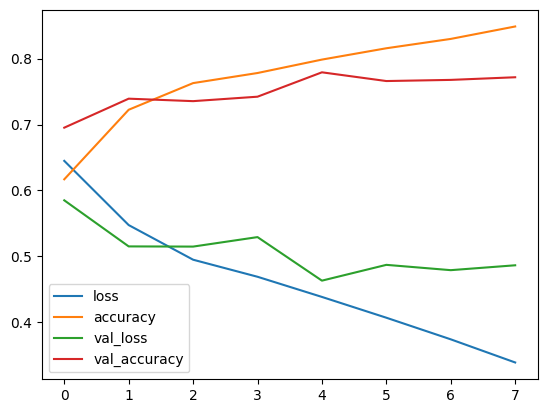

In [38]:
pd.DataFrame(history.history).plot()

# Evaluate
Probemos los datos en el conjunto de test.

In [39]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

157/157 [==============================] - 2s 12ms/step - loss: 0.4722 - accuracy: 0.7814
test loss, test acc: [0.47216522693634033, 0.7814000248908997]


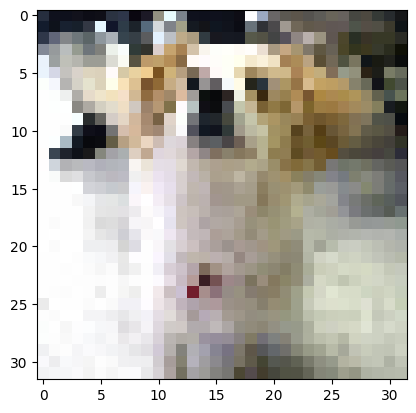

In [40]:
plt.imshow(X_test[-30]);

In [37]:
X_test[1].reshape(1, 32, 32, 3)

array([[[[0.24313725, 0.25098039, 0.23921569],
         [0.23921569, 0.24705882, 0.23529412],
         [0.24705882, 0.25882353, 0.23137255],
         ...,
         [0.28627451, 0.2627451 , 0.21568627],
         [0.29411765, 0.2627451 , 0.21960784],
         [0.28235294, 0.25490196, 0.22745098]],

        [[0.21568627, 0.22352941, 0.20392157],
         [0.21568627, 0.22352941, 0.20392157],
         [0.23137255, 0.24313725, 0.21568627],
         ...,
         [0.29019608, 0.26666667, 0.21960784],
         [0.29019608, 0.26666667, 0.21960784],
         [0.29019608, 0.2745098 , 0.22745098]],

        [[0.23921569, 0.24705882, 0.22745098],
         [0.23921569, 0.24705882, 0.22745098],
         [0.23529412, 0.24705882, 0.23137255],
         ...,
         [0.28627451, 0.2627451 , 0.21568627],
         [0.29019608, 0.26666667, 0.21960784],
         [0.29411765, 0.27058824, 0.22352941]],

        ...,

        [[0.23529412, 0.21176471, 0.16470588],
         [0.24313725, 0.21960784, 0.17254902]

In [38]:
predictions = model.predict(X_test[-30].reshape(1, 32, 32, 3)).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 [==============================] - 0s 93ms/step
predictions shape: (1, 1)


array([[0.91]], dtype=float32)

# Image data generator

In [44]:
'''
NO genera X imagenes sinteticas. Simplemente en cada epoch, en vez de coger el
dataset tal cual lo tiene, coge una de esas imágenes sintéticas, algo diferentes,
Asi eumentan sus perspectivas
Las imagenes las va generando segun entrena
https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

'''

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [46]:
df_train

NameError: name 'df_train' is not defined

In [45]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode="binary"
)

ValueError: If class_mode="binary" there must be 2 classes. Found 1 classes.

NameError: name 'example_generator' is not defined

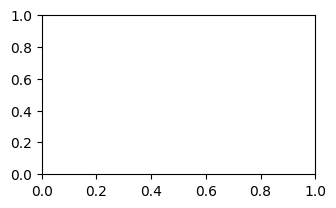

In [42]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [50]:
filenames = os.listdir(MINI_TRAIN_PATH)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')

df_2 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [47]:
train_df, validate_df = train_test_split(df_2,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

NameError: name 'df_2' is not defined

In [52]:
train_df

,filename,category
0,cat.5373.jpg,0
1,cat.2913.jpg,0
2,cat.8822.jpg,0
3,cat.737.jpg,0
4,cat.549.jpg,0
...,...,...
15995,dog.11416.jpg,1
15996,dog.12172.jpg,1
15997,cat.480.jpg,0
15998,cat.10963.jpg,0


In [53]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 16000
Shape validation 4000


,filename,category
0,dog.10713.jpg,1
1,cat.12299.jpg,0
2,cat.8497.jpg,0
3,cat.11242.jpg,0
4,dog.3112.jpg,1


In [54]:
train_df.head()

,filename,category
0,cat.5373.jpg,0
1,cat.2913.jpg,0
2,cat.8822.jpg,0
3,cat.737.jpg,0
4,cat.549.jpg,0


# Training Generator

In [48]:
train_df = pd.read_csv("train_files.csv")
train_df["category"] = train_df["filename"].apply(lambda x: x.split('.')[0])
# train_df["category"] = train_df["category"].replace({"dog": 1, "cat": 0})
train_df.head()

,filename,category
0,cat.7986.jpg,cat
1,dog.4066.jpg,dog
2,dog.1049.jpg,dog
3,dog.6732.jpg,dog
4,dog.2250.jpg,dog


Found 1 validated image filenames belonging to 1 classes.


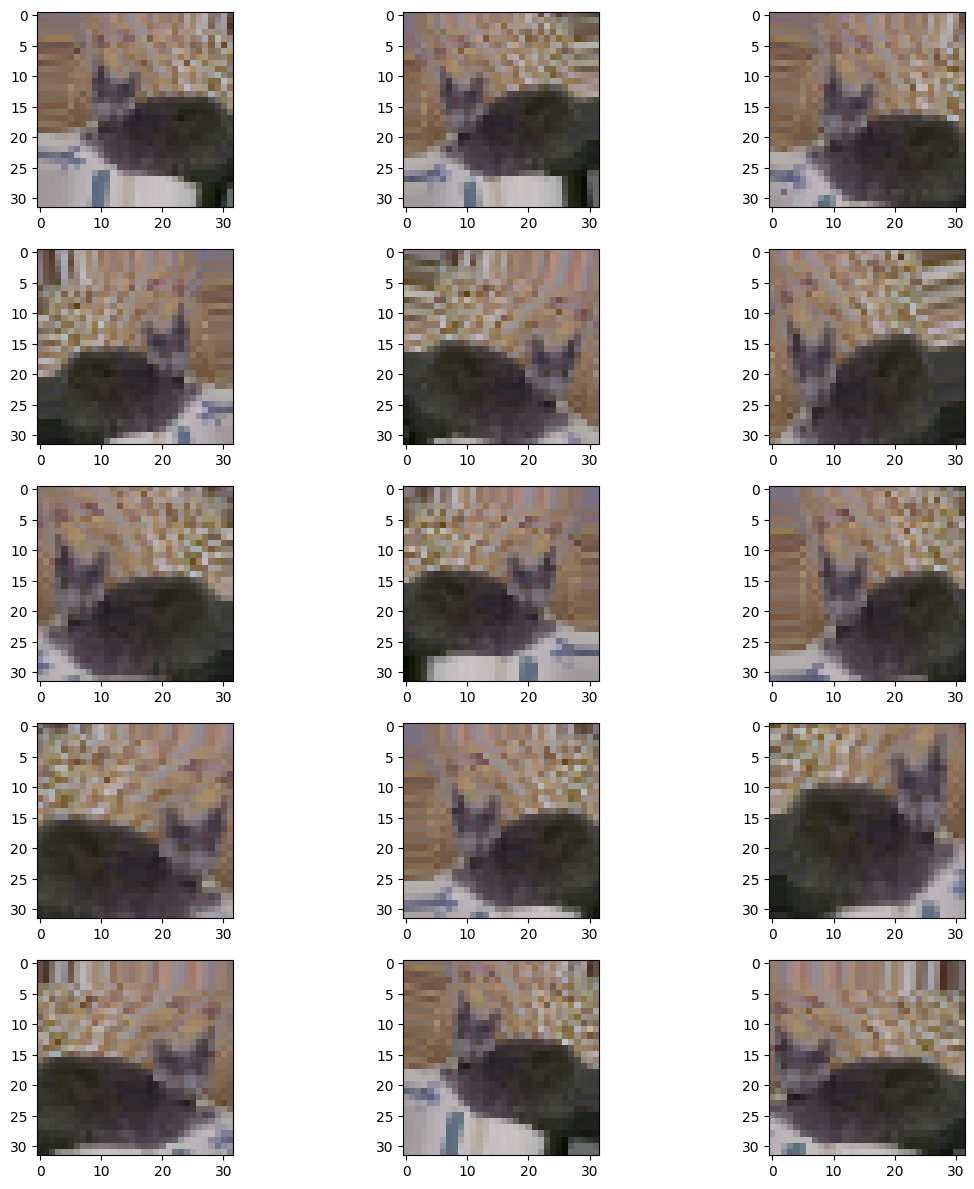

In [51]:
example_df = train_df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    # class_mode=""
)

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [56]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    MINI_TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [57]:
validate_df = pd.read_csv("test_files.csv")
validate_df["category"] = validate_df["filename"].apply(lambda x: x.split('.')[0])
# train_df["category"] = train_df["category"].replace({"dog": 1, "cat": 0})
validate_df.head()

,filename,category
0,dog.11481.jpg,dog
1,cat.680.jpg,cat
2,dog.7639.jpg,dog
3,cat.9695.jpg,cat
4,cat.3139.jpg,cat


In [58]:


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    MINI_TEST_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


# Fit Model

In [59]:
from keras.models import Sequential
model = Sequential(layers)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [60]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    callbacks=[earlystop]
)

Epoch 1/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.5138 - accuracy: 0.7458 - val_loss: 0.5144 - val_accuracy: 0.7296
Epoch 2/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.4981 - accuracy: 0.7558 - val_loss: 0.5050 - val_accuracy: 0.7460
Epoch 3/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.4794 - accuracy: 0.7695 - val_loss: 0.4330 - val_accuracy: 0.7968
Epoch 4/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.4742 - accuracy: 0.7731 - val_loss: 0.4460 - val_accuracy: 0.7866
Epoch 5/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.4650 - accuracy: 0.7775 - val_loss: 0.4269 - val_accuracy: 0.7906
Epoch 6/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.4583 - accuracy: 0.7819 - val_loss: 0.4093 - val_accuracy: 0.8166
Epoch 7/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.4536 - accuracy: 0.7858 - val_loss: 0.5190 -

<AxesSubplot: >

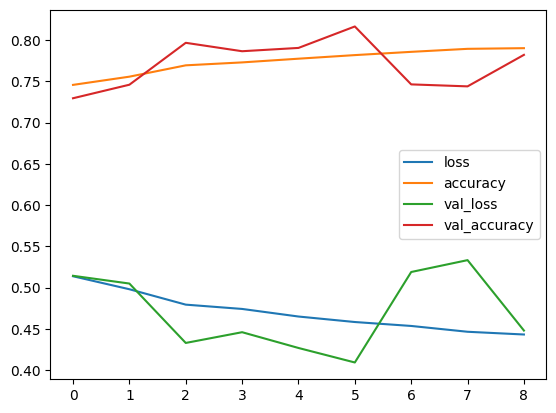

In [61]:
pd.DataFrame(history.history).plot()

In [62]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

157/157 [==============================] - 2s 12ms/step - loss: 0.4360 - accuracy: 0.7856
test loss, test acc: [0.43600624799728394, 0.7856000065803528]


# Save Model

In [63]:
model.save_weights("model.h5")

# Virtualize Training

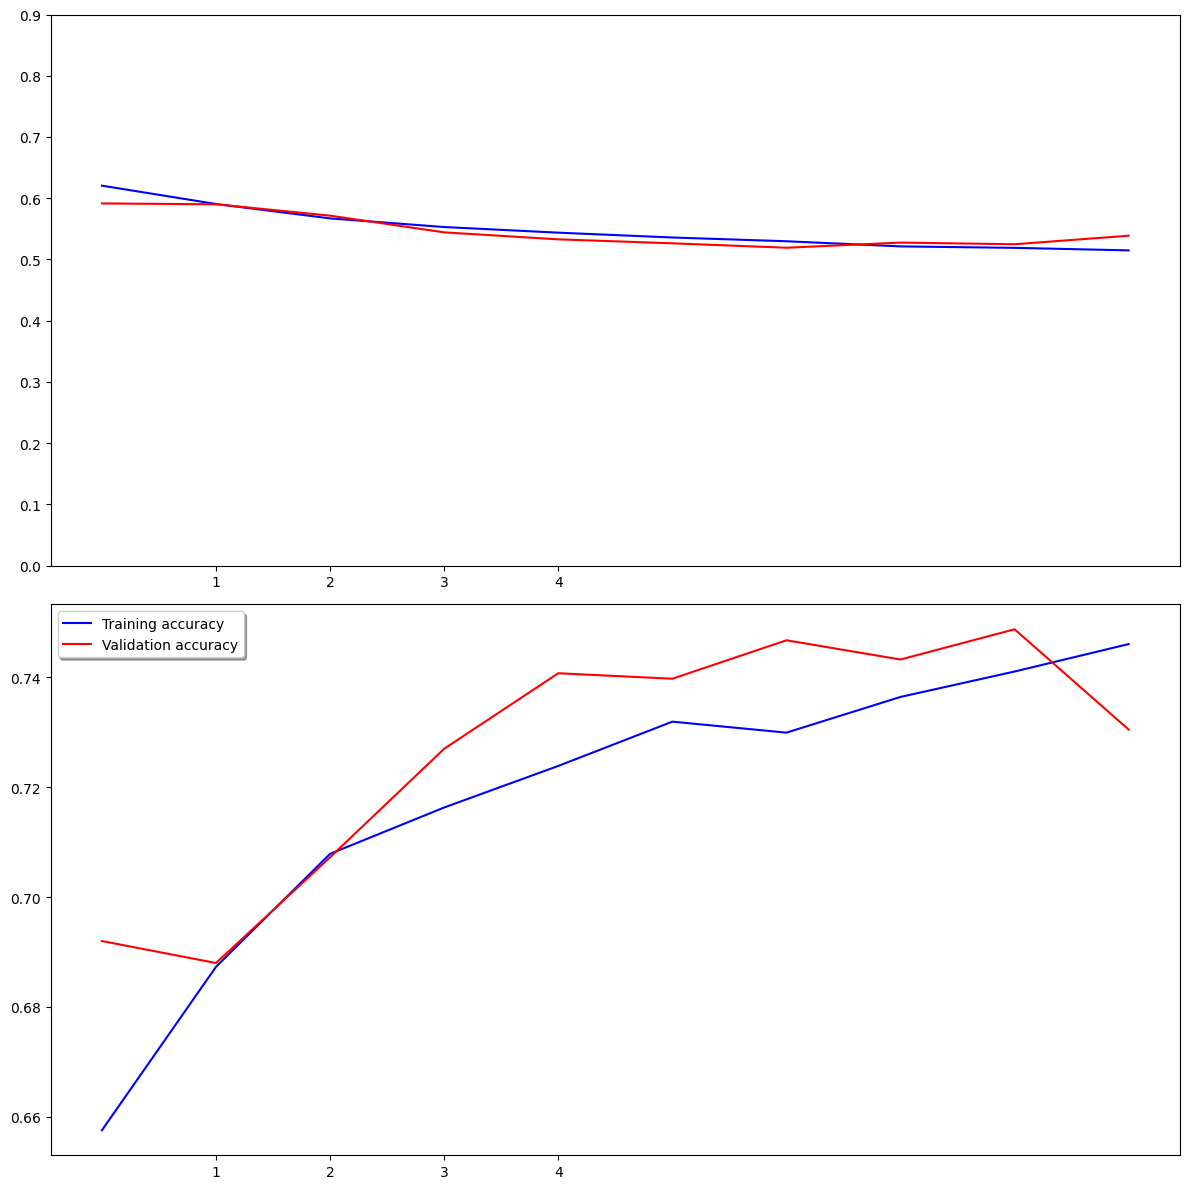

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

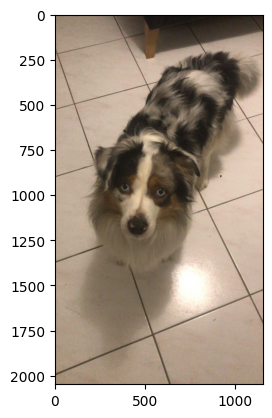

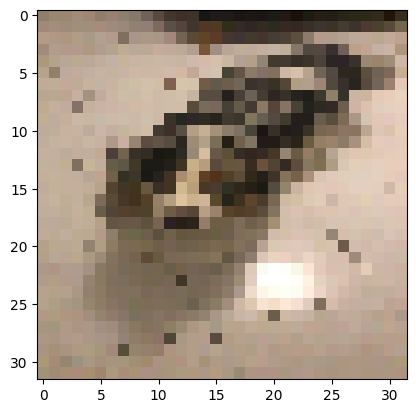

In [80]:
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(ROOT_PATH + 'new_images\\dog.genesis.jpg')
plt.imshow(image)
plt.show()
image = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))/255.0])
plt.imshow(image.reshape(32, 32, 3));

In [81]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 [==============================] - 0s 62ms/step
predictions shape: (1, 1)


array([[0.853]], dtype=float32)

In [90]:
from skimage.io import imread
# pip install opencv-python 
import cv2

def plot_pred(filename):
    image = imread(ROOT_PATH + 'new_images\\' + filename)
    plt.imshow(image)
    # plt.show()
    image = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))/255.0])
    predictions = model.predict(image).round(3)[0, 0]
    animal = 'cat' if predictions < .5 else 'dog'
    # plt.imshow(image.reshape(32, 32, 3))
    plt.title(f"This is a {animal} ({predictions:.3f})");

1/1 [==============================] - 0s 22ms/step


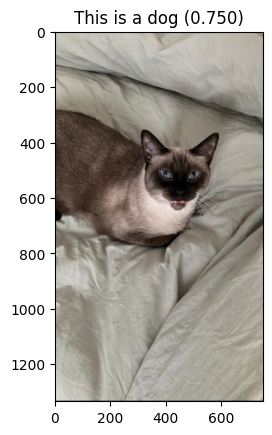

In [93]:
plot_pred('cat.julio.jpg')

1/1 [==============================] - 0s 19ms/step


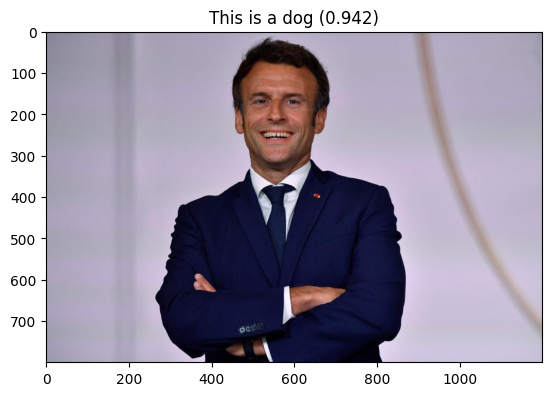

In [94]:
plot_pred('dog.macron.jpg')

1/1 [==============================] - 0s 19ms/step


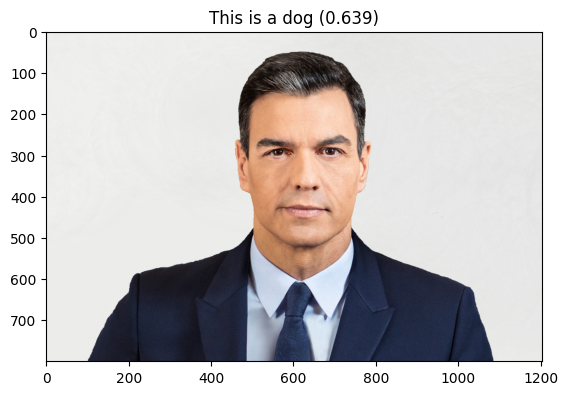

In [95]:
plot_pred('dog.sanchez.jpg')

1/1 [==============================] - 0s 29ms/step


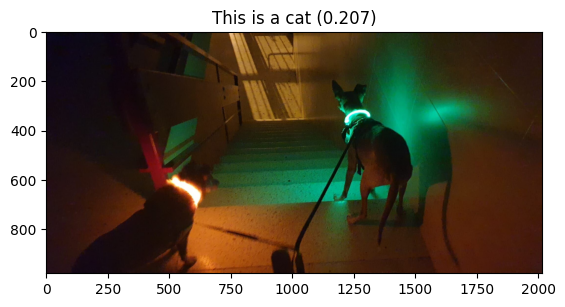

In [96]:
plot_pred('dog.guille.jpg')